## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

## Load Data

In [3]:
pd.set_option('display.max_columns', None)

train_df = pd.read_csv('../data/train.csv')
train_df.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,203995,0,36.0,1,1,7.0,0.179869,1,2,5.0,0.295967,3.0,0,3.0,0,4,1,1.0,0.295967,21537.0
1,202610,0,42.0,1,1,21.0,0.177555,1,3,4.0,0.295967,3.0,1,6.0,0,4,1,2.0,0.295967,21129.0
2,203083,0,50.0,1,1,7.0,0.265861,0,3,4.0,0.295967,5.0,0,4.0,0,4,1,1.0,0.295967,22258.0
3,203973,0,38.0,1,1,7.0,0.177555,1,3,5.0,0.118692,3.0,1,3.0,0,5,0,1.0,0.118692,24671.0
4,204044,0,44.0,0,1,35.0,0.179869,0,4,2.0,0.295967,3.0,0,6.0,0,3,0,3.0,0.295967,23417.0


In [4]:
test_df = pd.read_csv('../data/test.csv')
test_df.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200144,0,32.0,0,3,9.0,0.202469,1,2,5.0,0.113846,3.0,1,1.0,0,2,0,1.0,0.113846,19668.0
1,200079,0,46.0,1,2,11.0,0.202469,1,3,0.0,0.113846,4.0,1,1.0,1,5,0,1.0,0.113846,20021.0
2,202098,0,37.0,1,3,22.0,0.202469,1,3,4.0,0.113846,3.0,1,5.0,0,5,1,0.0,0.113846,21334.0
3,204738,0,43.0,1,1,36.0,0.202469,1,3,6.0,0.113846,3.0,0,6.0,0,3,1,2.0,0.113846,22950.0
4,202858,1,25.0,1,3,7.0,0.310680,0,4,4.0,0.313984,4.0,0,3.0,1,4,1,3.0,0.313984,21880.0


In [5]:
# Drop CustomerID column from both train and test datasets
train_df = train_df.drop(columns=['CustomerID'])
test_df = test_df.drop(columns=['CustomerID'])

## Pre-Processing

### Check Multicollinearity of Variables

In [6]:
Z = train_df.copy()
Z['constant'] = 1

#compute VIF
vif_data = pd.DataFrame({
    'Variable': Z.columns,
    'VIF': [variance_inflation_factor(Z.values, i) for i in range(Z.shape[1])]
})

vif_data = vif_data[vif_data['Variable'] != 'constant'].sort_values(by='VIF', ascending=False)

print(vif_data)

                    Variable       VIF
9             ProductPitched       inf
17               Designation       inf
18             MonthlyIncome  1.816060
7     NumberOfPersonVisiting  1.680740
16  NumberOfChildrenVisiting  1.565343
1                        Age  1.385491
0                  ProdTaken  1.236151
8          NumberOfFollowups  1.194911
3                   CityTier  1.110400
13                  Passport  1.093440
12             NumberOfTrips  1.087668
11             MaritalStatus  1.024686
10     PreferredPropertyStar  1.022861
4            DurationOfPitch  1.017219
5                 Occupation  1.016263
14    PitchSatisfactionScore  1.014870
15                    OwnCar  1.012714
6                     Gender  1.011382
2              TypeofContact  1.009733


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


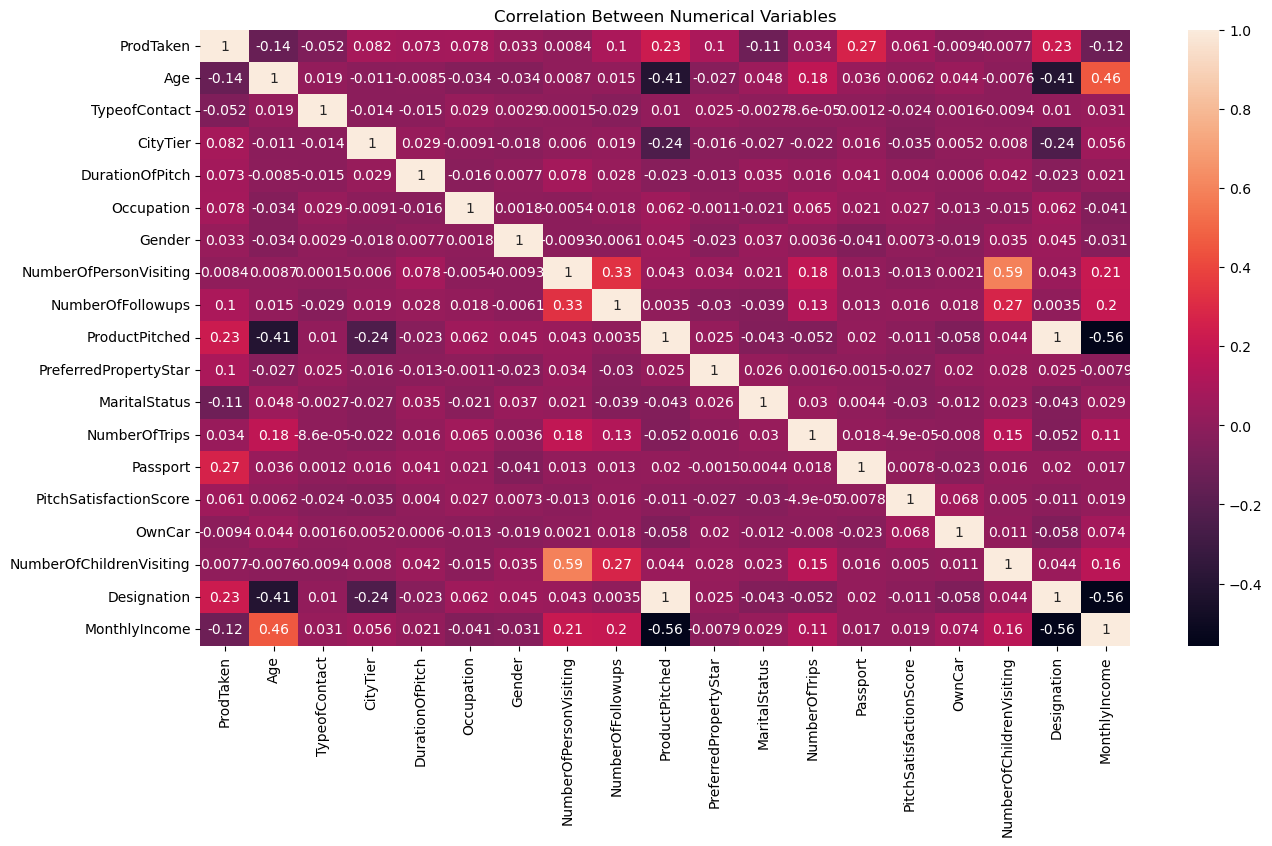

In [7]:
#check correlation
plt.figure(figsize = (15, 8))
corr = train_df.corr()
sns.heatmap(corr, annot = True)
plt.title('Correlation Between Numerical Variables')
plt.show()

**Insight:**

`Designation` and `ProductPitched` has a very high VIF score (inf) and correlation (1), which might indicate overrepresentation, and multicollinearity, and so will be dropped.

In [8]:
#remove multicollinear variables
train_df = train_df.drop(columns = ['Designation'])
test_df = test_df.drop(columns = ['Designation'])

## Outlier Handling of Training Set

In [9]:
import scipy.stats as stats

In [10]:
# function to graph
def check_plot(df, variable):
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # plot Q-Q
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # box plot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

In [11]:
columns_to_check = ['Age','DurationOfPitch', 'NumberOfTrips','MonthlyIncome']

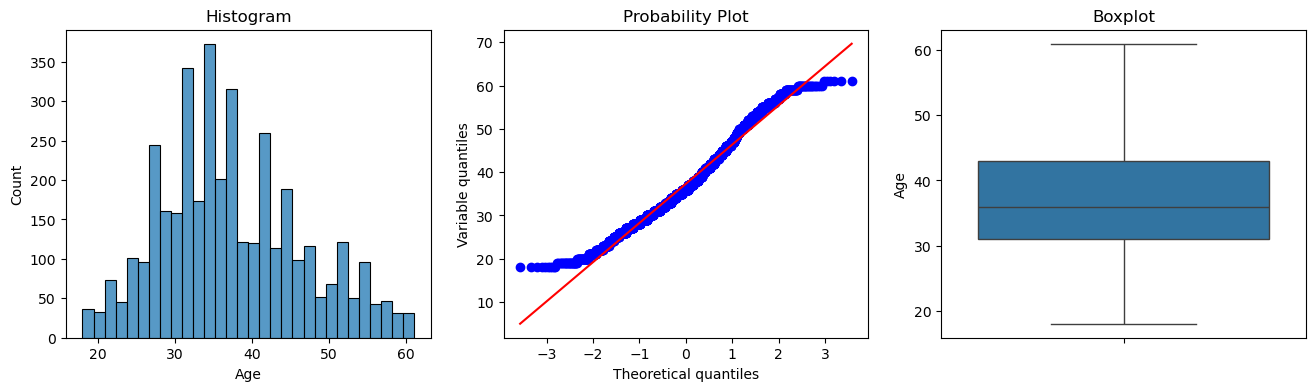

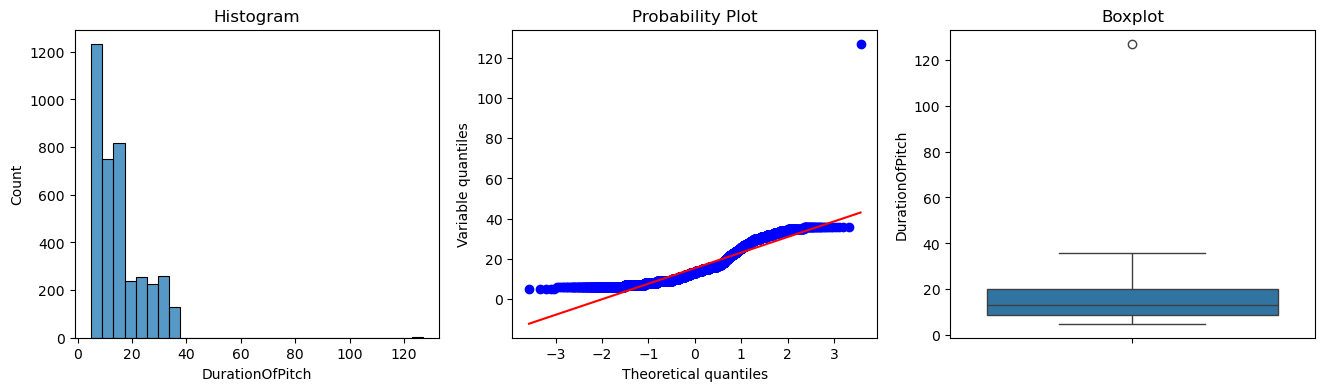

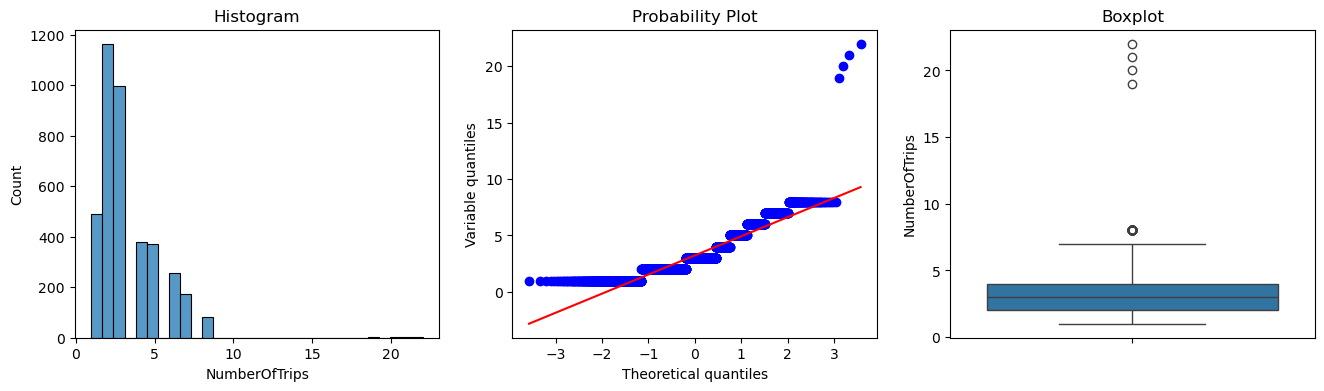

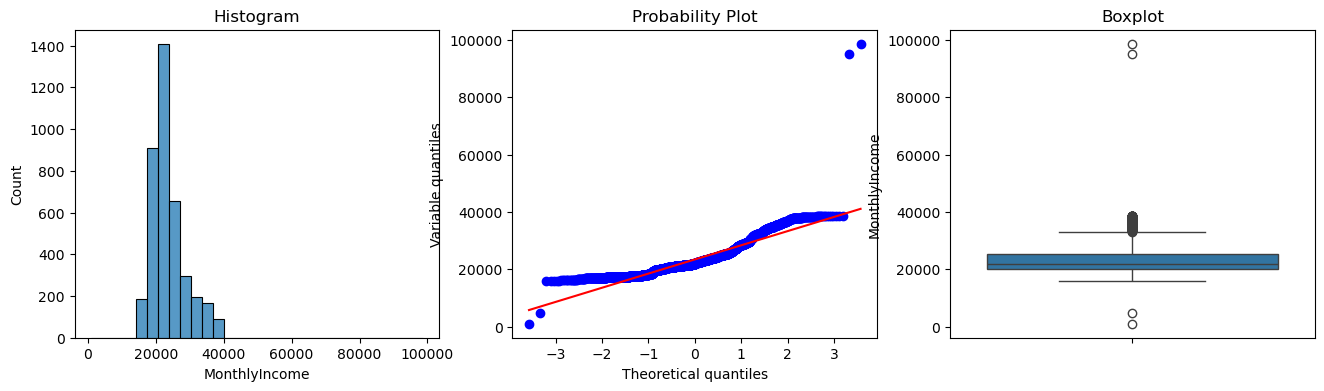

In [12]:
for col in columns_to_check:
  check_plot(train_df, col)

In [13]:
# function to find IQR of variables
def find_outlier_boundary(df, variable):

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * 1.5)
    upper_boundary = df[variable].quantile(0.75) + (IQR * 1.5)

    return upper_boundary, lower_boundary

In [14]:
pitch_upper_limit, pitch_lower_limit = find_outlier_boundary(train_df, 'DurationOfPitch')
print(f'Bounds for Duration of Pitch: {pitch_upper_limit, pitch_lower_limit}')


trips_upper_limit, trips_lower_limit = find_outlier_boundary(train_df, 'NumberOfTrips')
print(f'Bounds for Number of Trips: {trips_upper_limit, trips_lower_limit}')

income_upper_limit, income_lower_limit = find_outlier_boundary(train_df, 'MonthlyIncome')
print(f'Bounds for DurationOfPitch: {income_upper_limit, income_lower_limit}')


Bounds for Duration of Pitch: (36.5, -7.5)
Bounds for Number of Trips: (7.0, -1.0)
Bounds for DurationOfPitch: (33068.875, 12489.875)


In [15]:
train_no_outliers = train_df[
    (train_df['DurationOfPitch'].between(pitch_lower_limit, pitch_upper_limit)) &
    (train_df['NumberOfTrips'].between(trips_lower_limit, trips_upper_limit)) &
    (train_df['MonthlyIncome'].between(income_lower_limit, income_upper_limit))
]

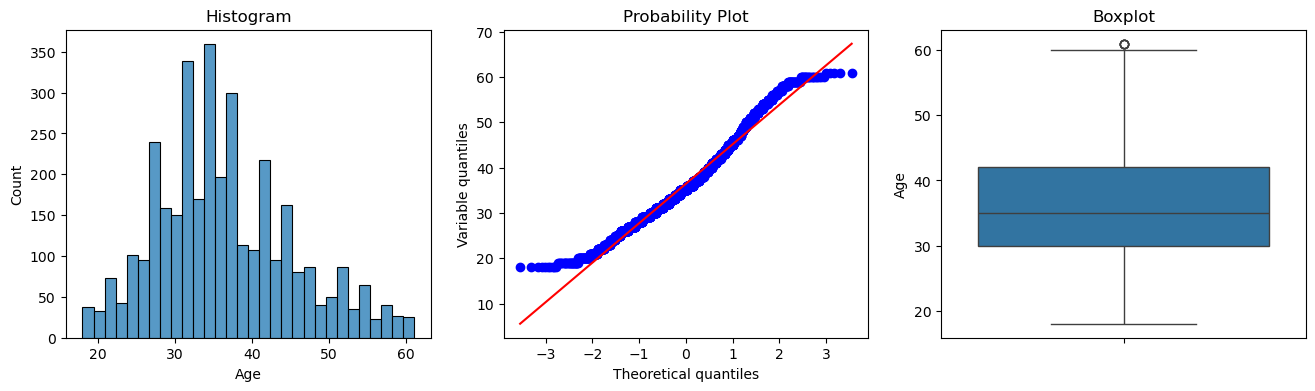

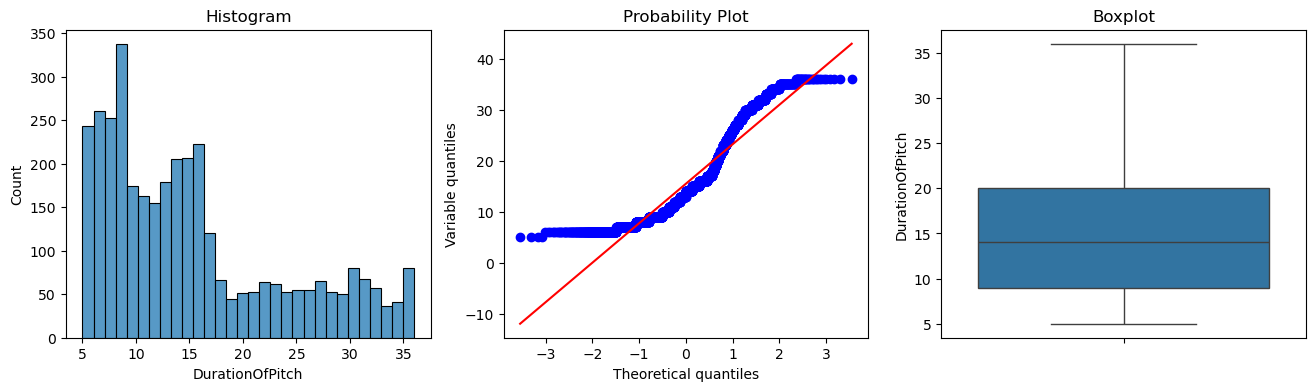

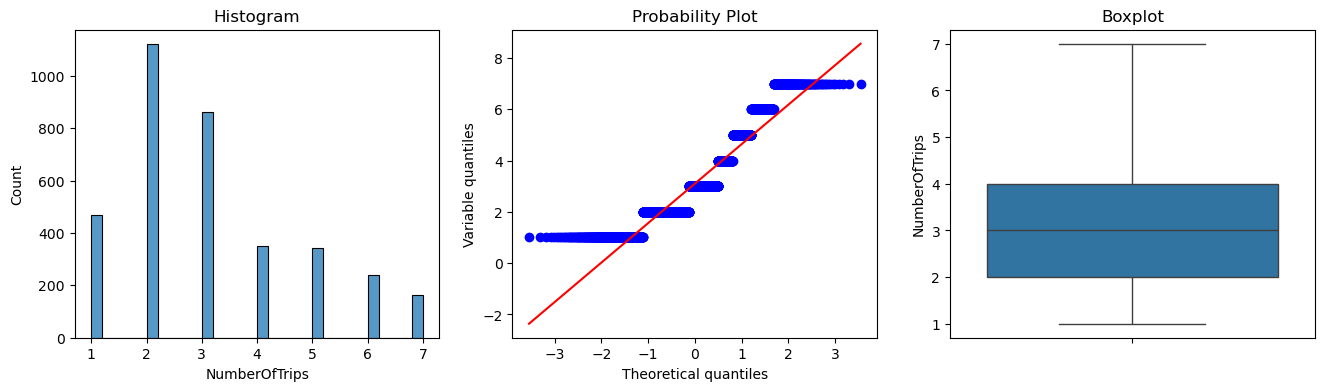

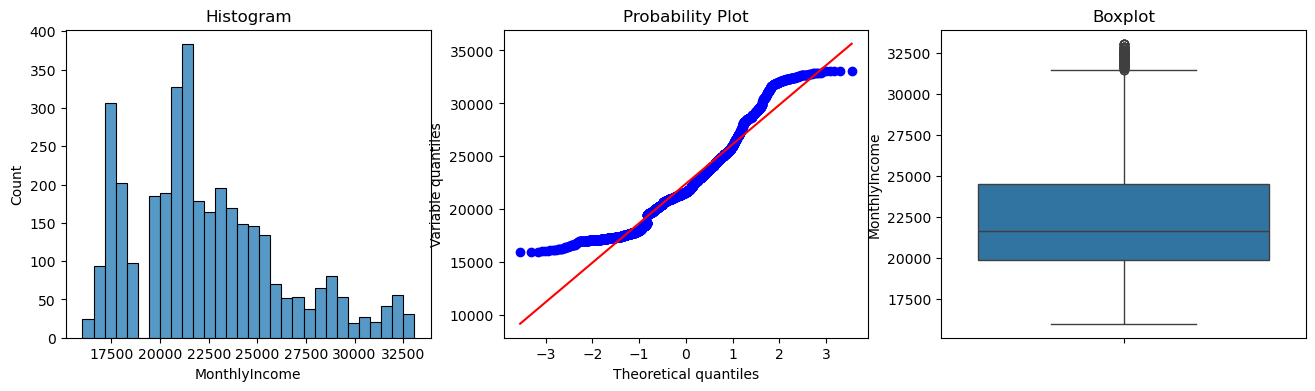

In [16]:
for col in columns_to_check:
  check_plot(train_no_outliers, col)

### Scaling for Logistic Regression (Base Model)

In [19]:
train_df.head()

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,MonthlyIncome
0,0,36.0,1,1,7.0,0.179869,1,2,5.0,0.295967,3.0,0,3.0,0,4,1,1.0,21537.0
1,0,42.0,1,1,21.0,0.177555,1,3,4.0,0.295967,3.0,1,6.0,0,4,1,2.0,21129.0
2,0,50.0,1,1,7.0,0.265861,0,3,4.0,0.295967,5.0,0,4.0,0,4,1,1.0,22258.0
3,0,38.0,1,1,7.0,0.177555,1,3,5.0,0.118692,3.0,1,3.0,0,5,0,1.0,24671.0
4,0,44.0,0,1,35.0,0.179869,0,4,2.0,0.295967,3.0,0,6.0,0,3,0,3.0,23417.0


In [18]:
train_df.describe()

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,MonthlyIncome
count,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.00000
mean,0.186445,37.337340,0.708184,1.662916,15.398721,0.186445,0.604348,2.906394,3.686957,0.186445,3.581074,0.479028,3.233760,0.285678,3.067263,0.619949,1.171355,23423.27289
std,0.389515,9.139941,0.454656,0.919046,8.314203,0.030490,0.489053,0.723777,1.049654,0.087879,0.801284,0.499624,1.830244,0.451794,1.372473,0.485461,0.862984,5336.98995
min,0.000000,18.000000,0.000000,1.000000,5.000000,0.177555,0.000000,1.000000,0.000000,0.062963,3.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1000.00000
25%,0.000000,31.000000,0.000000,1.000000,9.000000,0.177555,0.000000,2.000000,3.000000,0.118692,3.000000,0.000000,2.000000,0.000000,2.000000,0.000000,1.000000,20207.00000
50%,0.000000,36.000000,1.000000,1.000000,13.000000,0.179869,1.000000,3.000000,4.000000,0.162479,3.000000,0.000000,3.000000,0.000000,3.000000,1.000000,1.000000,21997.00000
75%,0.000000,43.000000,1.000000,3.000000,20.000000,0.179869,1.000000,3.000000,4.000000,0.295967,4.000000,1.000000,4.000000,1.000000,4.000000,1.000000,2.000000,25351.75000
max,1.000000,61.000000,1.000000,3.000000,127.000000,1.000000,1.000000,5.000000,6.000000,0.295967,5.000000,1.000000,22.000000,1.000000,5.000000,1.000000,3.000000,98678.00000


In [20]:
columns_to_scale = ['Age', 'DurationOfPitch', 'CityTier', 'Occupation', 
                    'NumberOfPersonVisiting', 'ProductPitched', 'PreferredPropertyStar',
                    'NumberOfTrips', 'PitchSatisfactionScore', 'NumberOfChildrenVisiting', 'MonthlyIncome']

scaler = StandardScaler()
train_df_scaled = train_df.copy()
train_df_scaled[columns_to_scale] = scaler.fit_transform(train_df_scaled[columns_to_scale])

test_df_scaled = test_df.copy()
test_df_scaled[columns_to_scale] = scaler.transform(test_df_scaled[columns_to_scale])


In [24]:
train_df_scaled.describe()

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,MonthlyIncome
count,3910.000000,3.910000e+03,3910.000000,3.910000e+03,3.910000e+03,3.910000e+03,3910.000000,3.910000e+03,3910.000000,3.910000e+03,3.910000e+03,3910.000000,3.910000e+03,3910.000000,3.910000e+03,3910.000000,3.910000e+03,3.910000e+03
mean,0.186445,-1.008571e-16,0.708184,-9.813122e-17,1.022200e-16,-7.196290e-16,0.604348,-5.451735e-18,3.686957,-1.789986e-16,1.998969e-17,0.479028,8.359326e-17,0.285678,-1.253899e-16,0.619949,8.177602e-17,4.724837e-17
std,0.389515,1.000128e+00,0.454656,1.000128e+00,1.000128e+00,1.000128e+00,0.489053,1.000128e+00,1.049654,1.000128e+00,1.000128e+00,0.499624,1.000128e+00,0.451794,1.000128e+00,0.485461,1.000128e+00,1.000128e+00
min,0.000000,-2.115967e+00,0.000000,-7.214003e-01,-1.250878e+00,-2.915996e-01,0.000000,-2.634290e+00,0.000000,-1.405310e+00,-7.252712e-01,0.000000,-1.220627e+00,0.000000,-1.506426e+00,0.000000,-1.357506e+00,-4.202020e+00
25%,0.000000,-6.934564e-01,0.000000,-7.214003e-01,-7.697118e-01,-2.915996e-01,0.000000,-1.252472e+00,3.000000,-7.710727e-01,-7.252712e-01,0.000000,-6.741818e-01,0.000000,-7.777204e-01,0.000000,-1.985871e-01,-6.027151e-01
50%,0.000000,-1.463370e-01,1.000000,-7.214003e-01,-2.885458e-01,-2.157073e-01,1.000000,1.293467e-01,4.000000,-2.727489e-01,-7.252712e-01,0.000000,-1.277368e-01,0.000000,-4.901521e-02,1.000000,-1.985871e-01,-2.672771e-01
75%,0.000000,6.196303e-01,1.000000,1.455047e+00,5.534947e-01,-2.157073e-01,1.000000,1.293467e-01,4.000000,1.246437e+00,5.228848e-01,1.000000,4.187083e-01,1.000000,6.796900e-01,1.000000,9.603316e-01,3.613879e-01
max,1.000000,2.589260e+00,1.000000,1.455047e+00,1.342469e+01,2.668622e+01,1.000000,2.892983e+00,6.000000,1.246437e+00,1.771041e+00,1.000000,1.025472e+01,1.000000,1.408395e+00,1.000000,2.119250e+00,1.410240e+01


### Feature Selection

In [22]:
X_train = train_df_scaled.drop(columns=['ProdTaken'])
y_train = train_df_scaled['ProdTaken']

X_test = test_df_scaled.drop(columns=['ProdTaken'])
y_test = test_df_scaled['ProdTaken']

## Model Selection

In [23]:
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

results = []

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)

    #predict on train
    y_pred_train = clf.predict(X_train)
    y_pred_train_probs = clf.predict_proba(X_train)[:, 1]

    #predict on test
    y_pred_test = clf.predict(X_test)
    y_pred_test_probs = clf.predict_proba(X_test)[:, 1]

    #evaluate on train
    precision_train = precision_score(y_train, y_pred_train, pos_label=1)
    recall_train = recall_score(y_train, y_pred_train, pos_label=1)
    f1_train = f1_score(y_train, y_pred_train, pos_label=1)
    roc_auc_train = roc_auc_score(y_train, y_pred_train_probs)

    #evaluate on test
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    f1_test = f1_score(y_test, y_pred_test, pos_label=1)
    roc_auc_test = roc_auc_score(y_test, y_pred_test_probs)

    #append results to list
    results.append({
        'Model': name,
        'Precision (train)': precision_train,
        'Recall (train)': recall_train,
        'F1-Score (train)': f1_train,
        'ROC AUC (train)': roc_auc_train,
        'Precision (test)': precision_test,
        'Recall (test)': recall_test,
        'F1-Score (test)': f1_test,
        'ROC AUC (test)': roc_auc_test
    })

#create dataframe
results_df = pd.DataFrame(results)
results_df

[LightGBM] [Info] Number of positive: 729, number of negative: 3181
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 398
[LightGBM] [Info] Number of data points in the train set: 3910, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.186445 -> initscore=-1.473277
[LightGBM] [Info] Start training from score -1.473277


,Model,Precision (train),Recall (train),F1-Score (train),ROC AUC (train),Precision (test),Recall (test),F1-Score (test),ROC AUC (test)
0,Logistic Regression,0.665563,0.275720,0.389913,0.802769,0.642857,0.329843,0.435986,0.805904
1,K-Nearest Neighbors,0.919214,0.577503,0.709351,0.967000,0.831579,0.413613,0.552448,0.867224
2,Decision Tree,1.000000,1.000000,1.000000,1.000000,0.769663,0.717277,0.742547,0.832590
3,Random Forest,1.000000,1.000000,1.000000,1.000000,0.966387,0.602094,0.741935,0.962749
4,XGBoost,1.000000,0.998628,0.999314,1.000000,0.883871,0.717277,0.791908,0.946500
5,LightGBM,0.996933,0.891632,0.941347,0.998501,0.893443,0.570681,0.696486,0.943393


Among the models evaluated, **XGBoost** stands out as the best-performing model. It achieved the highest F1-Score on the test set (0.79) while maintaining a high ROC AUC score (0.95), indicating both strong precision-recall balance and excellent overall classification ability.

While Decision Tree and Random Forest also performed well, their perfect training scores suggest overfitting. In contrast, XGBoost maintains strong generalization without sacrificing performance.

Therefore, XGBoost is the most reliable model for this classification task.

## Model Training and Evaluation with XGBoost

### Base Model

In [25]:
#retrieve model
xgb = classifiers['XGBoost']

#fit model
xgb.fit(X_train, y_train)

#predict on train and test
base_pred_train = xgb.predict(X_train)
base_pred_train_probs = xgb.predict_proba(X_train)[:, 1]

base_pred_test = xgb.predict(X_test)
base_pred_test_probs = xgb.predict_proba(X_test)[:, 1]

#evaluate
base_train_metrics = {
    'Precision': precision_score(y_train, base_pred_train, pos_label=1),
    'Recall': recall_score(y_train, base_pred_train, pos_label=1),
    'F1-Score': f1_score(y_train, base_pred_train, pos_label=1),
    'ROC AUC': roc_auc_score(y_train, base_pred_train_probs)
}

base_test_metrics = {
    'Precision': precision_score(y_test, base_pred_test, pos_label=1),
    'Recall': recall_score(y_test, base_pred_test, pos_label=1),
    'F1-Score': f1_score(y_test, base_pred_test, pos_label=1),
    'ROC AUC': roc_auc_score(y_test, base_pred_test_probs)
}

base_evaluation_df = pd.DataFrame([base_train_metrics, base_test_metrics], index=['Train', 'Test'])
base_evaluation_df

,Precision,Recall,F1-Score,ROC AUC
Train,1.000000,0.998628,0.999314,1.0000
Test,0.883871,0.717277,0.791908,0.9465


### Tuned XGBoost

To reduce the effect of overfitting, the parameters will be tuned using Randomized Search Cross Validation as follows:


In [26]:
#define model
tuned_xgb = XGBClassifier(random_state=42, eval_metric='logloss')

#define parameters
param_grid = {
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1]
}

#set up cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#set up f1 scoring
f1_scorer = make_scorer(f1_score)

#random search
random_search = RandomizedSearchCV(tuned_xgb, param_grid, n_iter=10, cv=5, scoring=f1_scorer, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

#the best parameter
print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Best set of hyperparameters:  {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0}
Best score:  0.75229544406186


In [27]:
#retrieve model
tuned_model = random_search.best_estimator_

#predict on train and test
tuned_pred_train = tuned_model.predict(X_train)
tuned_pred_train_probs = tuned_model.predict_proba(X_train)[:, 1]

tuned_pred_test = tuned_model.predict(X_test)
tuned_pred_test_probs = tuned_model.predict_proba(X_test)[:, 1]

#evaluate
tuned_train_metrics = {
    'Precision': precision_score(y_train, tuned_pred_train, pos_label=1),
    'Recall': recall_score(y_train, tuned_pred_train, pos_label=1),
    'F1-Score': f1_score(y_train, tuned_pred_train, pos_label=1),
    'ROC AUC': roc_auc_score(y_train, tuned_pred_train_probs)
}

tuned_test_metrics = {
    'Precision': precision_score(y_test, tuned_pred_test, pos_label=1),
    'Recall': recall_score(y_test, tuned_pred_test, pos_label=1),
    'F1-Score': f1_score(y_test, tuned_pred_test, pos_label=1),
    'ROC AUC': roc_auc_score(y_test, tuned_pred_test_probs)
}

tuned_evaluation_df = pd.DataFrame([tuned_train_metrics, tuned_test_metrics], index=['Train', 'Test'])
tuned_evaluation_df

,Precision,Recall,F1-Score,ROC AUC
Train,1.000000,1.000000,1.000000,1.000000
Test,0.964029,0.701571,0.812121,0.957643


### Tuned XGBoost with SMOTE

Since the target data is imbalance, we can try to improve using oversampling techniques, such as SMOTE:

In [28]:
#define model
smote_xgb = XGBClassifier(random_state=42, eval_metric='logloss')

#define parameters
param_grid = {
    'xgb__max_depth': [3, 6, 10],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__n_estimators': [100, 200, 300],
    'xgb__subsample': [0.7, 0.8, 1.0],
    'xgb__gamma': [0, 0.1, 0.2],
    'xgb__reg_alpha': [0, 0.1, 1],
    'xgb__reg_lambda': [0, 0.1, 1]
}

#set up pipeline
pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=42)),  #apply SMOTE to training data within in each fold
    ('xgb', smote_xgb)
])

#set up cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#set up scoring
f1_scorer = make_scorer(f1_score)

#random search
smote_random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, n_iter=10, cv=cv, scoring=f1_scorer, random_state=42, verbose=1)

#fit
smote_random_search.fit(X_train, y_train)

#the best parameter
print("Best set of hyperparameters: ", smote_random_search.best_params_)
print("Best F1 score: ", smote_random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best set of hyperparameters:  {'xgb__subsample': 0.8, 'xgb__reg_lambda': 1, 'xgb__reg_alpha': 0, 'xgb__n_estimators': 300, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0}
Best F1 score:  0.7239830982861105


In [30]:
#retrieve model
smote_model = smote_random_search.best_estimator_

#predict on train and test
smote_pred_train = smote_model.predict(X_train)
smote_pred_train_probs = smote_model.predict_proba(X_train)[:, 1]

smote_pred_test = smote_model.predict(X_test)
smote_pred_test_probs = smote_model.predict_proba(X_test)[:, 1]

#evaluate
smote_train_metrics = {
    'Precision': precision_score(y_train, smote_pred_train, pos_label=1),
    'Recall': recall_score(y_train, smote_pred_train, pos_label=1),
    'F1-Score': f1_score(y_train, smote_pred_train, pos_label=1),
    'ROC AUC': roc_auc_score(y_train, smote_pred_train_probs)
}

smote_test_metrics = {
    'Precision': precision_score(y_test, smote_pred_test, pos_label=1),
    'Recall': recall_score(y_test, smote_pred_test, pos_label=1),
    'F1-Score': f1_score(y_test, smote_pred_test, pos_label=1),
    'ROC AUC': roc_auc_score(y_test, smote_pred_test_probs)
}

smote_evaluation_df = pd.DataFrame([smote_train_metrics, smote_test_metrics], index=['Train', 'Test'])
smote_evaluation_df

,Precision,Recall,F1-Score,ROC AUC
Train,1.000000,1.000000,1.000000,1.0000
Test,0.823864,0.759162,0.790191,0.9464


### Model Analysis

In [31]:
evaluation_df = pd.DataFrame([base_train_metrics, base_test_metrics,
                              tuned_train_metrics, tuned_test_metrics,
                              smote_train_metrics,smote_test_metrics],
                             index = ['Base XGBoost Train', 'Base XGBoost Test',
                                      'Tuned XGBoost(without SMOTE) Train', 'Tuned XGBoost(without SMOTE) Train',
                                      'Tuned XGBoost with SMOTE Train', 'Tuned XGBoost with SMOTE Test'])
evaluation_df

,Precision,Recall,F1-Score,ROC AUC
Base XGBoost Train,1.000000,0.998628,0.999314,1.000000
Base XGBoost Test,0.883871,0.717277,0.791908,0.946500
Tuned XGBoost(without SMOTE) Train,1.000000,1.000000,1.000000,1.000000
Tuned XGBoost(without SMOTE) Train,0.964029,0.701571,0.812121,0.957643
Tuned XGBoost with SMOTE Train,1.000000,1.000000,1.000000,1.000000
Tuned XGBoost with SMOTE Test,0.823864,0.759162,0.790191,0.946400


**Observations:**

- Tuned XGBoost shows improvement over the base model in all metrics (precision, recall, F1-score, and ROC-AUC), indicating a better balance between precision and recall and improved overall discriminatory power. It shows that hyperparameter tuning successfully enhanced the model's performance without compromising generalization.
- On the other hand, SMOTE implementation slightly reduces the overall performance (precision, recall, F1-score, ROC-AUC drops). This is likely due to introducing noise in the synthetic samples, making it less effective compared to the tuned model without SMOTE.


The **Tuned XGBoost Model (Without SMOTE)** is the best-performing model. It provides the highest precision, recall, F1-Score, and ROC AUC, indicating a robust and balanced performance.

<Figure size 800x600 with 0 Axes>

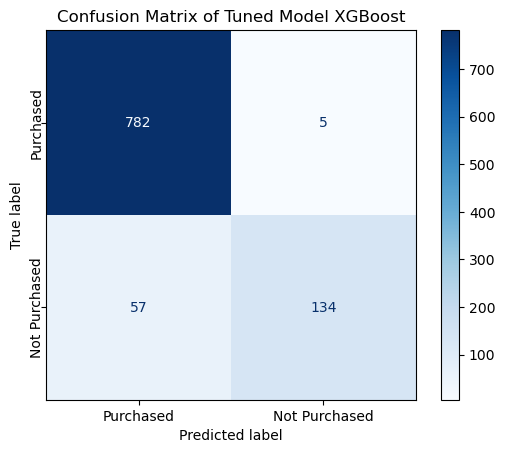

In [32]:
#confusion matrix of tuned XGBoost

cm_tuned = confusion_matrix(y_test, tuned_pred_test)
tuned_display = ConfusionMatrixDisplay(confusion_matrix=cm_tuned, display_labels=['Purchased', 'Not Purchased'])

plt.figure(figsize=(8, 6))
tuned_display.plot(cmap='Blues', values_format='d')
plt.yticks(rotation=90, ha='center', va='center')
plt.title('Confusion Matrix of Tuned Model XGBoost')
plt.show()

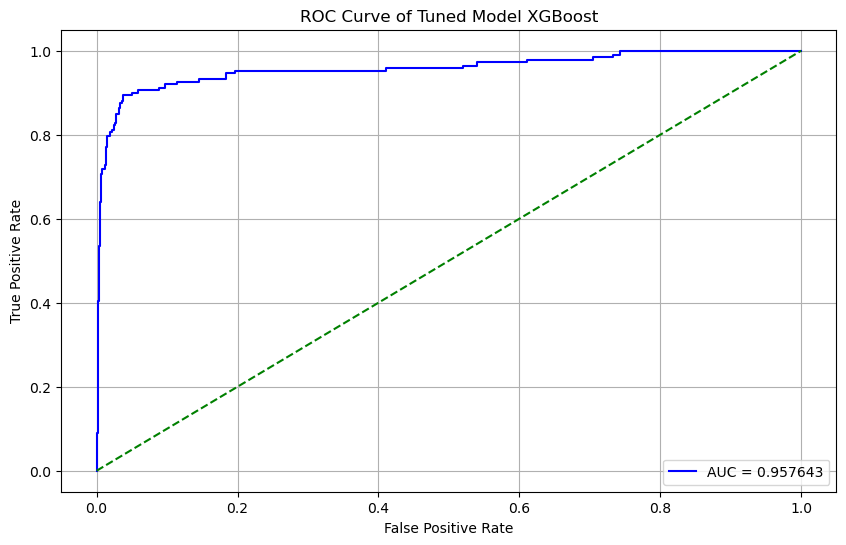

In [33]:
#check ROC-AUC curve and result

tuned_fpr, tuned_tpr, tuned_thresholds = roc_curve(y_test, tuned_pred_test_probs)
tuned_roc_auc = roc_auc_score(y_test, tuned_pred_test_probs)

plt.figure(figsize=(10, 6))
plt.plot(tuned_fpr, tuned_tpr, color='blue', label=f'AUC = {tuned_roc_auc:.6f}')
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.title('ROC Curve of Tuned Model XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

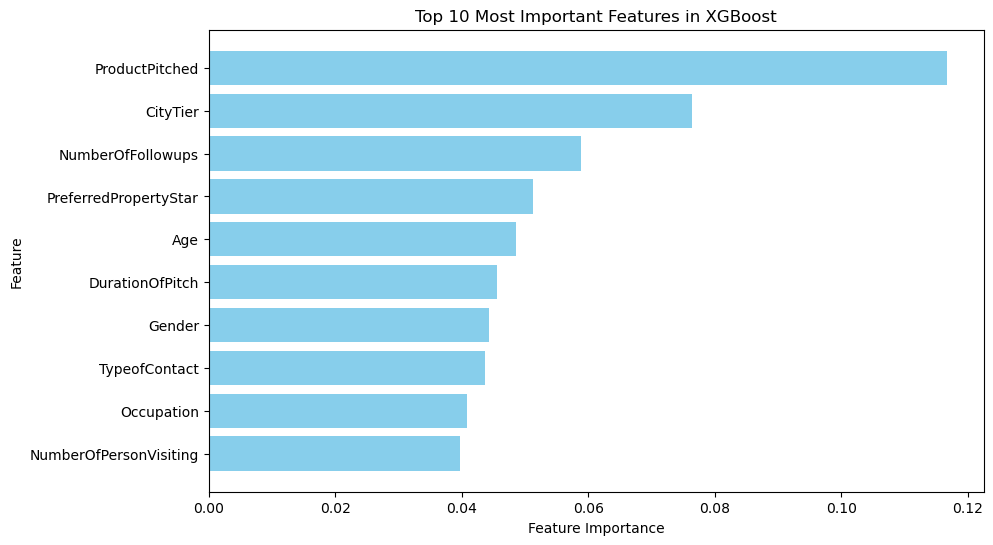

                  Feature  Importance
8          ProductPitched    0.116638
2                CityTier    0.076410
7       NumberOfFollowups    0.058793
9   PreferredPropertyStar    0.051247
0                     Age    0.048615
3         DurationOfPitch    0.045615
5                  Gender    0.044256
1           TypeofContact    0.043597
4              Occupation    0.040794
6  NumberOfPersonVisiting    0.039793


In [34]:
importances = tuned_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

top_10_features = feature_importance_df.head(10).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features in XGBoost')
plt.gca().invert_yaxis()  # To display the most important features at the top
plt.show()

print(top_10_features)

## Actionable Insights Based on Feature Importance

**1. Number of Follow-ups**: customers with more follow-ups are significantly more likely to purchase
- Implement automated and personalized follow-up campaigns.
- Set a minimum number of follow-up contacts for each lead before closing the case.
- Train marketing teams to persistently engage with potential buyers.

**2. Product Pitched**: certain products (e.g., Basic or Standard) have higher conversion rates
- Start pitches with the most popular product.
- Use A/B testing to refine which product resonates best with each segment.
- Upsell higher-tier packages only after initial interest.

**3. City Tier**: customers from specific city tiers (e.g., Tier 3) are more receptive
- Allocate more marketing budget and resources to high-conversion city tiers. 
- Develop city-specific campaigns and leverage local testimonials.

**4. Duration of Pitch**: longer, more informative pitches correlate with higher purchase rates.
- Train sales staff to deliver comprehensive, value-focused presentations.
- Provide scripts and materials that encourage deeper engagement.

**5. Occupation**: Freelancers and business owners are more likely to buy.
- Create targeted offers and messaging for these occupations.
- Highlight flexibility, premium experiences, and business travel benefits.

**6. Number of Persons Visiting**: group travelers (2–4 people) are more likely to purchase
- Promote group discounts and family/friends packages.
- Use referral incentives for group bookings.

**7. Income Group**: higher income groups show greater interest and ability to purchase
- Personalize offers for higher-income segments. For lower-income groups, emphasize affordability and value.

**8. Pitch Satisfaction Score**: higher satisfaction with the sales pitch increases conversion
- Collect feedback after pitches and continuously improve sales scripts and training.

**9. Preferred Property Star**: preference for 5-star properties is common, but not exclusive
- Offer a range of property options, but highlight premium experiences in marketing to affluent segments.

**10. Age**: age is a top predictor of purchase likelihood
- Segment marketing campaigns by age group. For younger customers, emphasize adventure and affordability; for older customers, highlight comfort, safety, and premium experiences.

---

**General Recommendations:**
- Use these insights to segment your customer base and tailor marketing strategies for each group.
- Regularly update the model and insights as new data becomes available.
- Monitor campaign effectiveness and adjust based on conversion data.